%matplotlib inline #使用jupyter notebook需要输出图像的话要加上这一行,或者写上 plt.show()

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
data_train = pd.read_csv("D:/YCR/Study/Statistic&Machine Learning/Kaggle/House/train.csv")

## 先研究SalePrice，也就是target

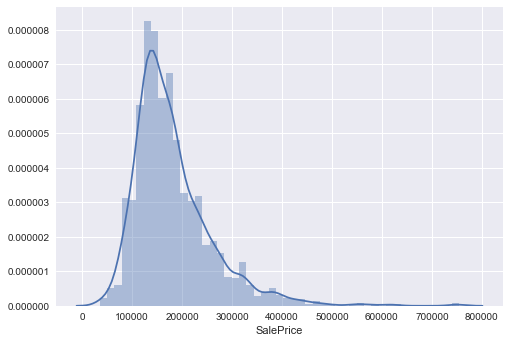

In [59]:
data_train.SalePrice.describe()
sns.distplot(data_train.SalePrice) #使用sns画出SalePrice的大致分布
plt.show()

可以看到 SalePrice 比较接近正态分布
顺便检查一下偏斜度和峰度

In [60]:
skewness = data_train.SalePrice.skew()  #偏斜度
kurtosis = data_train.SalePrice.kurt()  #峰度
print('skewness =', skewness)
print('kurtosis =', kurtosis)

skewness = 1.88287575977
kurtosis = 6.53628186006


## 如何从一大堆feature中找到有用的？   
### 使用sns.heatmap 

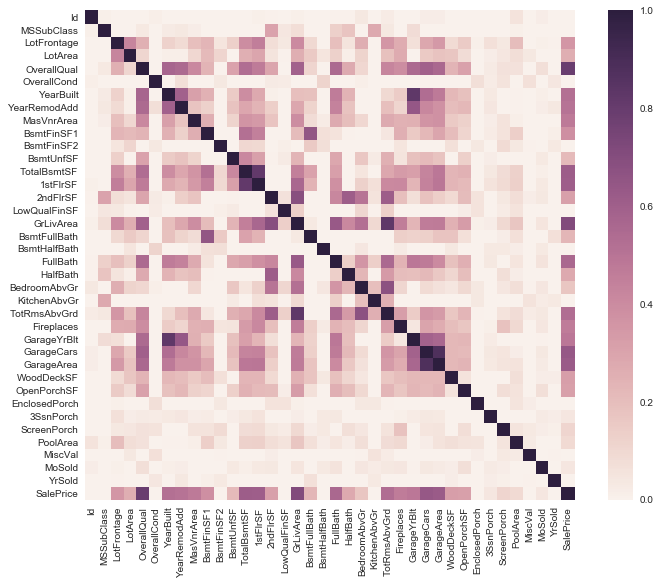

In [61]:
corrmat = data_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,vmin=0, vmax=1, square=True)
plt.show()

根据图可以看出 overqual,GrLiveArea,FullBath,Lotfrontage,YearBuilt, YearRomodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF
TotRmsAbvGr, GarageCars, GarageArea 都是和SalesPrice关联较大的
除此之外，也可以注意到TotalBsmtSF和1stFlrSF关联很大，还有其他有关联的feature，要注意**多重共线性**

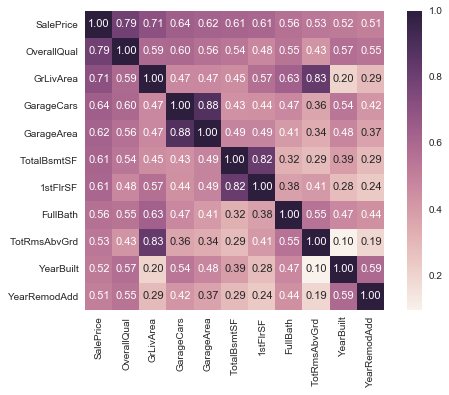

In [62]:
#把这些特别相关的拿出来再来画个heatmap
k = 11 #和SalePrice特别相关的feature数量
features = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cmap = np.corrcoef(data_train[features].values.T)
heatmap = sns.heatmap(cmap, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=features.values, xticklabels=features.values)
plt.show()

从图中也可以看出 GrLivArea和TotRmsAbvGrd 关联度很高，只用GrLivArea
GarageArea和 GarageCars关联度很高，只用GarageCars
TotalBsmtSF 和 1stFlrSF 关联度很高，只用TotalBsmtSF

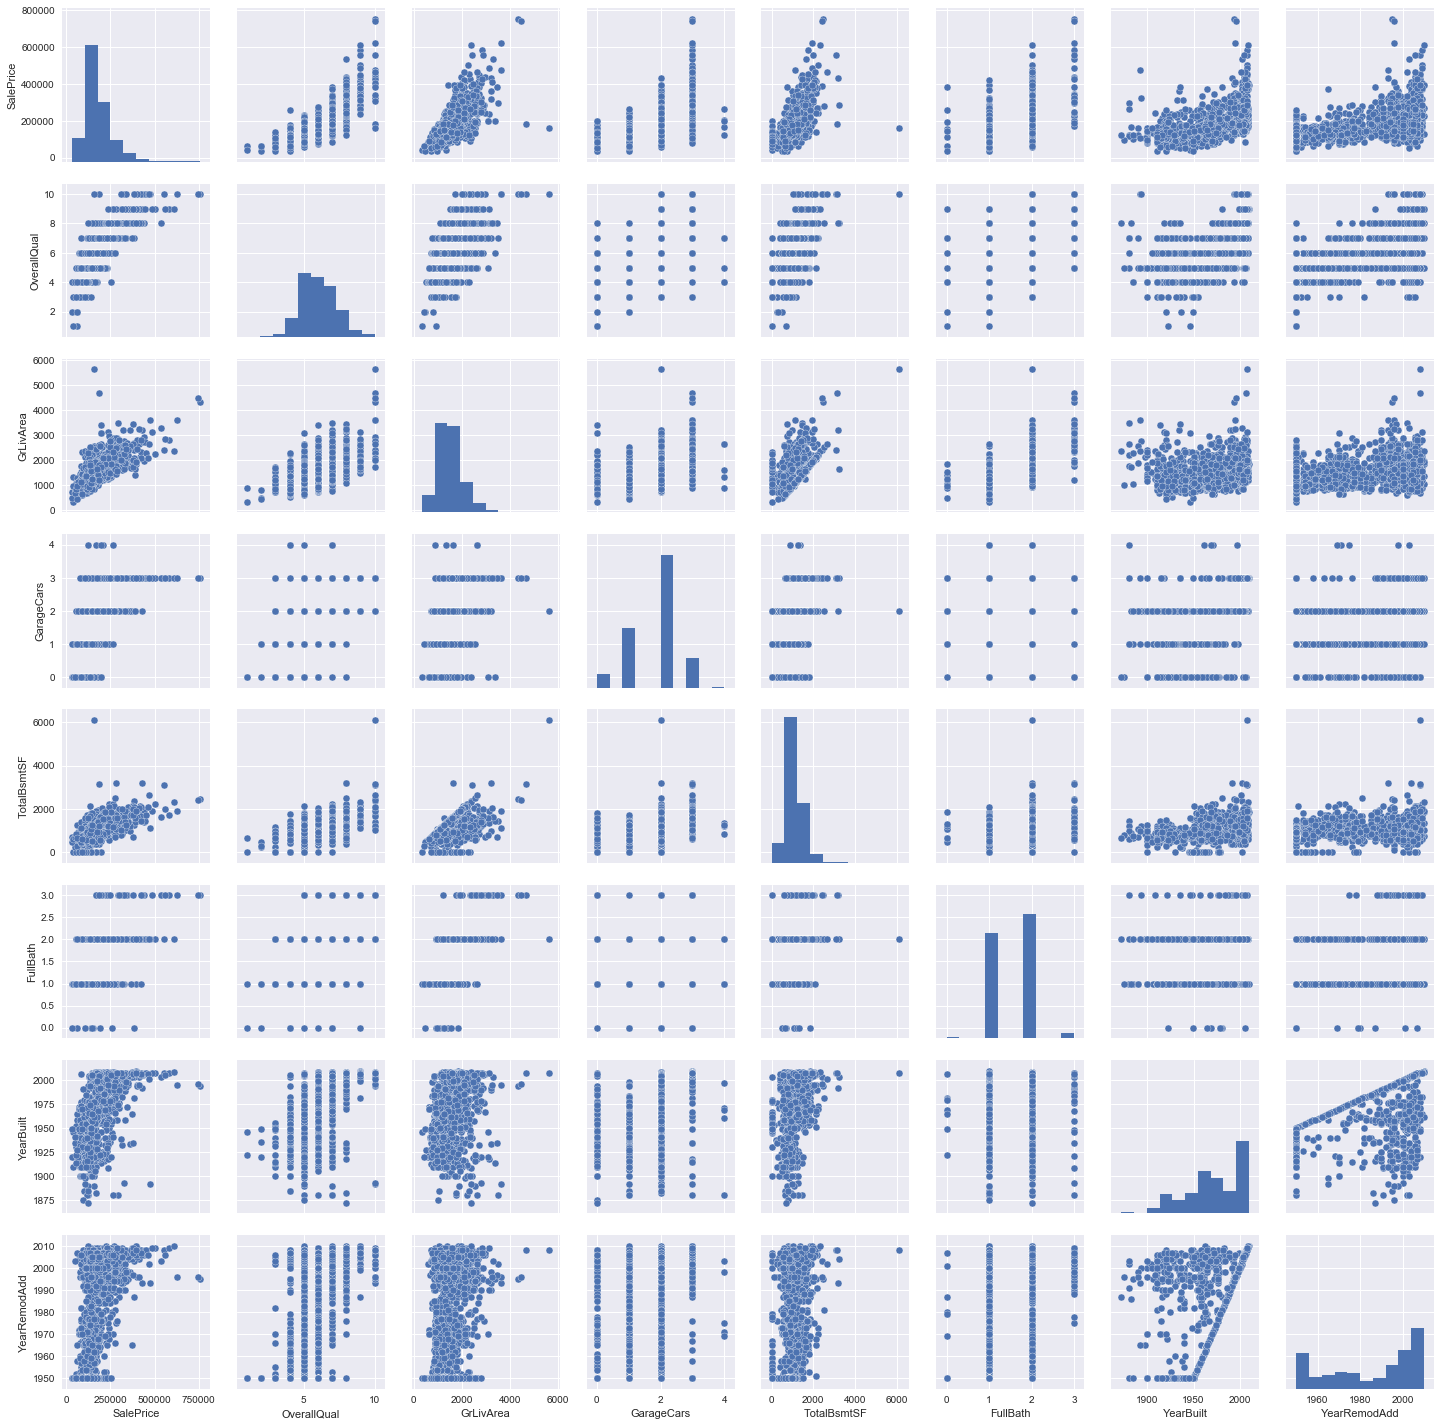

In [63]:
#如果要大致的看这些变量之间的关系可以画个pairplot
sns.set()
features = ['SalePrice', 'OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt','YearRemodAdd']
sns.pairplot(data_train[features], size = 2.5)
plt.show()

好的，那么我们差不多就是要用这些features了
注意他们和SalePrice的关联以及**他们之间的一些关联**
'SalePrice', 'OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt','YearRemodAdd'

## 接下来开始处理 MissingData

In [64]:
#首先来看一下哪些数据 miss了
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

非常幸运，我们要用的八个变量都没有missing data

## Outlier
那么我们现在来处理一下异常：**Outlier**
我们可以通过[sklearn](http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html)来实现异常检测  
sklearn提供了4种异常检测的方法，根据数据是否是高斯分布、数据的维度等等各有优劣，然而，这些方法是需要事先知道有多少异常点的

考虑到SalePrice的分布与正态分布很相近，我们在这里简单的看看分布比较极端的那些数据，也就是简单采用基于标准差的办法

In [65]:
data_train.loc[(data_train.SalePrice>data_train.SalePrice.quantile(0.99)),'SalePrice'] 
#这里直接认为超出99%之外的数据是outlier

178     501837
185     475000
440     555000
527     446261
591     451950
691     755000
769     538000
798     485000
803     582933
898     611657
1046    556581
1169    625000
1182    745000
1243    465000
1373    466500
Name: SalePrice, dtype: int64

In [66]:
#这是另一种方法，把边缘的数据输出来，看一看是不是异常
from sklearn.preprocessing import StandardScaler
saleprice_scaled = StandardScaler().fit_transform(data_train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[ 3.82897043]
 [ 4.04098249]
 [ 4.49634819]
 [ 4.71041276]
 [ 4.73032076]
 [ 5.06214602]
 [ 5.42383959]
 [ 5.59185509]
 [ 7.10289909]
 [ 7.22881942]]


D:\Python\anaconda\Anaconda\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


看上去并没有什么异常
除了那两个7.几，要小心

接下来明确的看一下我们选择的features和target之间的关系
'SalePrice', 'OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt','YearRemodAdd'

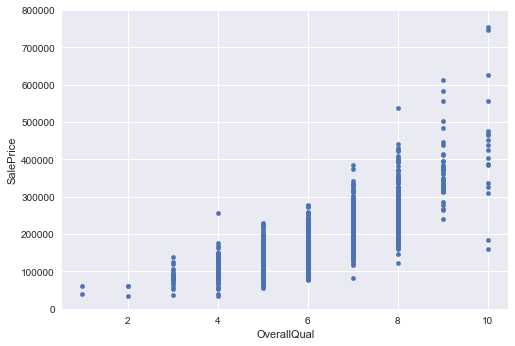

In [67]:
var = 'OverallQual'
data = pd.concat([data_train.SalePrice,data_train[var]],axis = 1)
data.plot.scatter(x = var, y='SalePrice', ylim=(0,800000))
plt.show()

OverallQual: Rates the overall material and finish of the house   
一个总评，看样子还是比较重要的   
OverallQual:离散变量，OverallQual越高，SalePrice越高  
OverallQual为10有两个SalePrice很低，可视为outlier

In [68]:
#看看这两个数据的Id
data_train.loc[(data_train.OverallQual == 10) & (data_train.SalePrice < 200000), ['Id']] #这里用的是loc函数的多列筛选

,Id
523,524
1298,1299


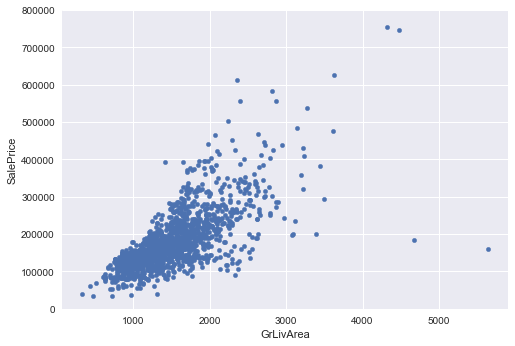

In [69]:
var = 'GrLivArea'
data = pd.concat([data_train.SalePrice,data_train[var]],axis = 1)
data.plot.scatter(x = var, y='SalePrice', ylim=(0,800000))
plt.show()

GrLivArea: Above grade (ground) living area square feet居住面积一类的    
GrLivArea：与SalePrice呈线性关系  
GrLivArea高于4000时上面有两个点，离得比较远，但是看上去趋势看上去没什么大问题，先放着  
下面也有两个点，居住面积很大，卖的却很便宜，看上去像outlier

In [70]:
#看看这两个数据的Id
#data_train.loc[(data_train.GrLivArea > 4000) & (data_train.SalePrice < 200000), ['Id']] 
#除了使用loc的多列筛选，也可以排个序筛选
data_train.sort_values(by = 'GrLivArea', ascending = False)[:2]  #ascending = False：降序，取最大的这两个

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


结果发现又是这两个，可以考虑删掉了

In [72]:
#删掉这两个
data_train = data_train.drop(data_train[data_train['Id'] == 1299].index)
data_train = data_train.drop(data_train[data_train['Id'] == 524].index)

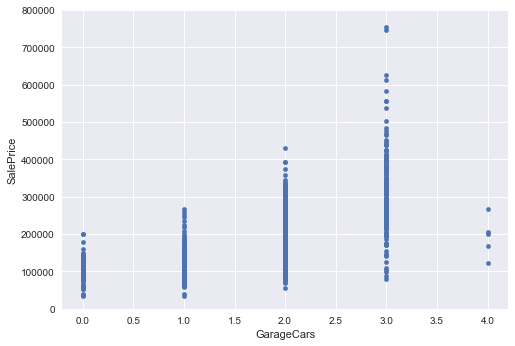

In [73]:
var = 'GarageCars'
data = pd.concat([data_train.SalePrice,data_train[var]],axis = 1)
data.plot.scatter(x = var, y='SalePrice', ylim=(0,800000))
plt.show()

GarageCars: Size of garage in car capacity   
GarageCars：离散型变量，GarageCars越高，SalePrice更多的分布在较高的水平（也有分布在较低水平的）  
比较特别的是当GarageCars为4.0时，SalePrice并没有分布在较高水平的  
可能是因为GarageCars太多了反而没有必要了   
输出这几个：

In [76]:
data_train.loc[(data_train.GarageCars == 4.0), :] 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
420,421,90,RM,78.0,7060,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Alloca,206300
747,748,70,RM,65.0,11700,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,265979
1190,1191,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1340,1341,20,RL,70.0,8294,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,6,2007,WD,Normal,123000
1350,1351,90,RL,91.0,11643,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,200000


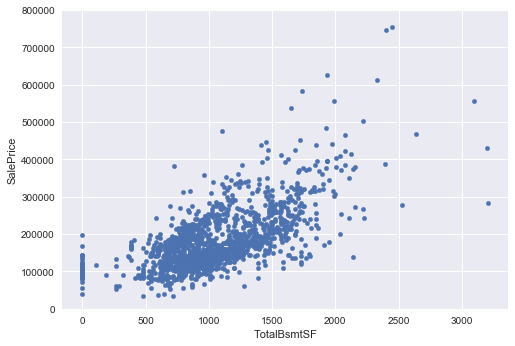

In [77]:
var = 'TotalBsmtSF'
data = pd.concat([data_train.SalePrice,data_train[var]],axis = 1)
data.plot.scatter(x = var, y='SalePrice', ylim=(0,800000))
plt.show()

TotalBsmtSF: Total square feet of basement area地下室面积   
TotalBsmtSF: 大于3000的三个点看上去有点奇怪  
这是一个可以等于0的连续型变量，我觉得需要把等于0和不等于0分开来看

In [79]:
data_train.loc[(data_train.TotalBsmtSF > 3000), :] 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
332,333,20,RL,85.0,10655,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,284000
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
496,497,20,RL,NaN,12692,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,430000


先放着好了 

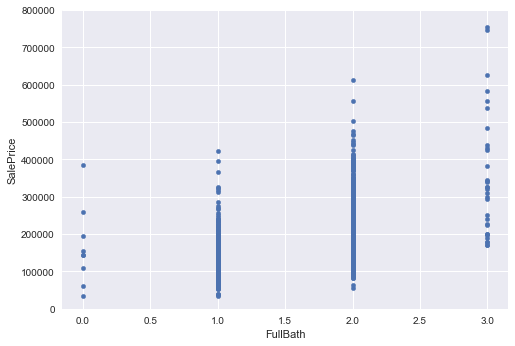

In [80]:
var = 'FullBath'
data = pd.concat([data_train.SalePrice,data_train[var]],axis = 1)
data.plot.scatter(x = var, y='SalePrice', ylim=(0,800000))
plt.show()

FullBath: Full bathrooms above grade 卫生间的数量   
FullBath：离散变量，基本与SalePrice呈正相关   
尤其是当FullBath有3个时，SalePrice高于150000   
没觉得有哪个是outlier

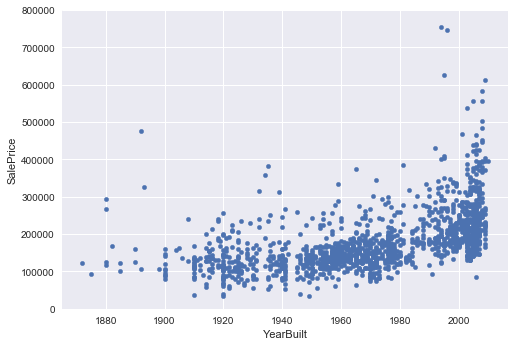

In [81]:
var = 'YearBuilt'
data = pd.concat([data_train.SalePrice,data_train[var]],axis = 1)
data.plot.scatter(x = var, y='SalePrice', ylim=(0,800000))
plt.show()

YearBuilt: Original construction date    
YearBuilt: 连续变量，基本上和SalePrice呈正相关（1880年的房子还能住？）   
其中建造时间在1880-1900，卖价高于400000的点值得一看

In [84]:
data_train.loc[(data_train.SalePrice > 400000) & (data_train.YearBuilt > 1880) & (data_train.YearBuilt < 1900), :] 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


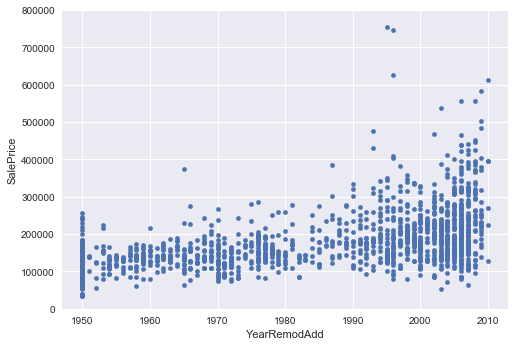

In [82]:
var = 'YearRemodAdd'
data = pd.concat([data_train.SalePrice,data_train[var]],axis = 1)
data.plot.scatter(x = var, y='SalePrice', ylim=(0,800000))
plt.show()

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)   
YearRemodAdd:这个变量与YearBuilt关系还比较大
注意这两个变量要不要一起用